<a href="https://colab.research.google.com/github/ChrysostomosS/Implementation-of-LASSO-method/blob/main/Lasso_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading Dataset

README File for details about the dataset. We load the "swiss" dataset in R and preview the 5 indicators for the first 10 french-speaking provinces.

In [1]:
data(swiss)
head(swiss,10)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6
Porrentruy,76.1,35.3,9,7,90.57,26.6
Broye,83.8,70.2,16,7,92.85,23.6
Glane,92.4,67.8,14,8,97.16,24.9
Gruyere,82.4,53.3,12,7,97.67,21.0


We observe that in the dataset there are 5 explanatory variables $Agriculture$, $Examination$, $Education$, $Catholic$ and $Infant.Mortality$ as well as the response variable $Fertility$ (variable of interest).

#Model Selection (AIC)

We start by choosing the best model using the AIC criterion, a naive yet useful way to highlight the Lasso method later on. You can skip to "LASSO" heading. We could use any given package that does this calculation on its own or built it on our own.

We construct such a function as explained below:

This function **initially** receives the explanatory variables x and the variable of response y. It registers the names of the explanatory variables in the variable $variables$ and the number of them in the variable $n$.
It then initializes the quantity $best\_aic$ to infinity, which will be used in the iterative process and will be renewed as it finds better models.

As for the **main operation of the function**, it makes use of nested loops, where the one loop is inside the other. In the outer loop, where it "runs" through every possible number of explanatory variables (p from 1 to n), with the help of the combn() function it calculates all possible combinations of p variables and stores them in the $combinations$ variable (the argument $simplify = FALSE$ ensures that the result of the function is returned as list).

It then enters the inner loop, where for each combination of the p explanatory variable constructs the following.

  • The formula of the linear model as ”y ∼ ” (response variable) by pasting to the right the variables contained in that iteration, separating them with a $'+'$.

  For example, for the explanatory variables x1 and x2, the formula would be ”y ∼ x1 + x2”.
  The $as.formula()$ function converts the string data type to an object
  which can be used to fit the model in a subsequent step.

  • A data frame containing the current explanatory variables and the
    of the response y.

Finally, it fits the model based on the formula and data calculated above.
If the AIC of the current model is smaller than the previous ones, it is stored in the variable $best\_aic$ and the model is registered as the $best_model$.

After the above procedure is done for all possible combinations of the explanatory variables, it returns a list containing the best model (based on the
AIC criterion) and the corresponding AIC value.

In [2]:
# Function to find the best model according to AIC
  find_best_model <- function(x, y) {
    variables <- colnames(x)
    n <- length(variables)

    # Initialize the best AIC as a large number
    best_aic <- Inf

    # Loop through all possible combinations of variables
    for (p in 1:n) {
      combinations <- combn(variables, p, simplify = FALSE)
      for (vars in combinations) {
        formula <- as.formula(paste("y ~", paste(vars, collapse = " + ")))
        model_data <- data.frame(y = y, x[, vars, drop = FALSE])
        model <- lm(formula, data = model_data)
        current_aic <- AIC(model)
        if (current_aic < best_aic) {
          best_aic <- current_aic
          best_model <- model
        }
      }
    }
    list(model = best_model, aic = best_aic)
  }

So in R, we define $y$ (response variable) as the quantitative characteristic that measures the fertility and $x$ as a matrix containing the 5 explanatory variables, subtracting all the columns except the first from the "swiss" dataset.

In [3]:
x <- as.matrix(swiss[, -1])
y <- swiss$Fertility

We then call the above function for our data and receive the best model (called M1) based on the AIC  along with its AIC value.

In [7]:
# Find the best model
  best_model_info <- find_best_model(x, y)
  M1 <- best_model_info$model
  best_model_aic <- best_model_info$aic

# Output the best model and its AIC
M1
best_model_aic


Call:
lm(formula = formula, data = model_data)

Coefficients:
     (Intercept)       Agriculture         Education          Catholic  
         62.1013           -0.1546           -0.9803            0.1247  
Infant.Mortality  
          1.0784  


[1] 325.2408

We notice that the final model includes 4 of the 5 explanatory variables (The second variable $Examination$ is missing). The final model is $\boxed{\hat{y} = 62.10 - 0.15 x_1 - 0.98 x_3 + 0.12 x_4 + 1.08 x_5}$

#LASSO

Using the glmnet library in R, we apply the **Lasso** method. In Lasso, we search for $β$ that minimize the quantity:

\begin{equation*}
    (y-Zβ)^{T} (y-Zβ) + λ\sum_{j=1}^p|β_j|
\end{equation*}

where Z: the matrix of normalized covariates, y the vector containing the values of the response variable.

For $λ=0$ there is no penalization while for greater values of $λ$ the term $\sum_{j=1}^p|β_j|$ reaches 0, with the least significant variables reaching 0 faster.

According to the plot of coefficients as a function of $log(λ)$ below, the variables x1 and x4 go to 0 faster as the penalty term $λ$ increases, meaninng they do not contribute to the modelsignificantly . In particular, the 1st variable zeroes out faster, with a significant difference from the
others, so it is expected not to be included in the model.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix

Loaded glmnet 4.1-8



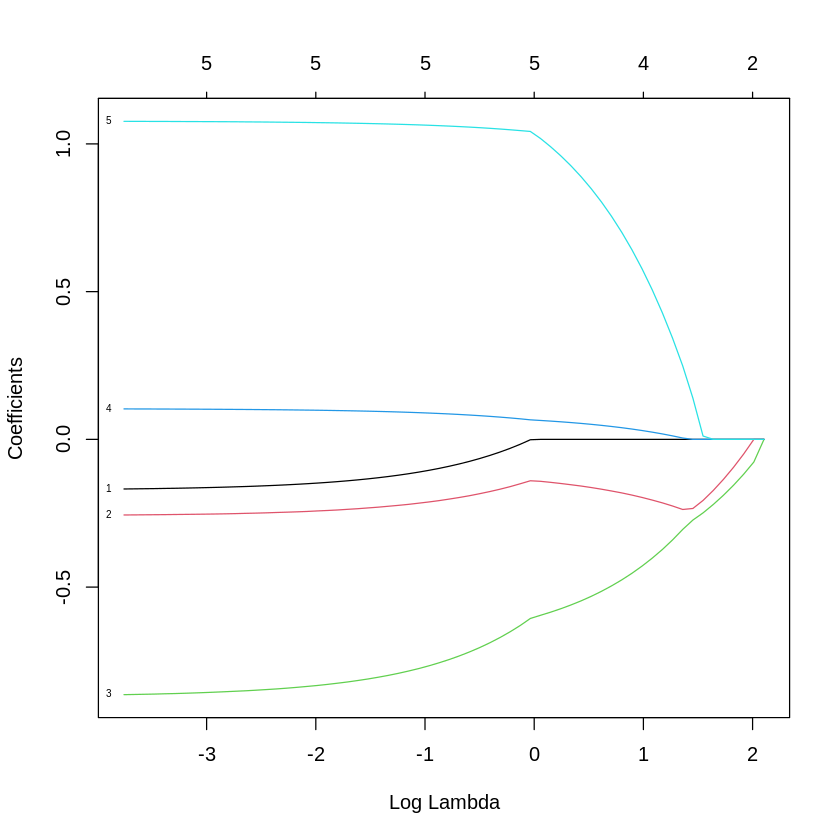

In [10]:
install.packages("glmnet")
library(glmnet)
lasso=glmnet(x,y)
plot(lasso, xvar="lambda", label=TRUE)

k-fold cross-validation using function $cv.glmnet$ gives the
$λ$ that minimizes the CV-MSE (mean square error) with an error that is within one standard deviation from the minimum value.

In [11]:
lasso1<-cv.glmnet(x,y)
lambda<-lasso1$lambda.1se
lambda

[1] 1.537123

We then calculate the model corresponding to the optimal $λ$.

As mentioned above, the $x_1$ variable ($Agriculture$) is not included in the final model, while the $x_4$ variable ($Catholic$) does not contribute significantly.

#Model Comparison

By comparison of the two models, we can see that the variables $x_1$ and $x_4$ had a small but not that insignificant effect in the first model (using AIC criterion), while being completely absent or insignificant in the second model (using Lasso method).

We proceed to install a package for data splitting to create training and testing data using the 80-20 rule.

In [55]:
install.packages("caTools")
library(caTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



We split the data, using 80% of it for training and 20% for testing purposes.

In [60]:
split <- sample.split(swiss$Fertility, SplitRatio = 0.8)  # 80% training, 20% testing
train_data <- as.data.frame(subset(swiss, split == TRUE))
test_data <- as.data.frame(subset(swiss, split == FALSE))

##Mean Square Error


MSE of M1 model.

In [62]:
y_pred_aic <- predict(M1, newdata = test_data)
mse_aic <- mean((test_data$Fertility - y_pred_aic)^2)
print(mse_aic)

[1] 68.04377


MSE of Lasso model.

In [64]:
y_pred_lasso <- predict(lasso1, s = "lambda.min", newx = as.matrix(test_data[, -1]))
mse_lasso <- mean((test_data$Fertility - y_pred_lasso)^2)
print(mse_lasso)

[1] 61.46415


We notice a smaller MSE for the Lasso model, indicating its superiority between the two.

##$R^2$ Coefficient of determination

In [81]:
r2_aic <- summary(M1)$r.squared
r2_aic

[1] 0.6993476

In [80]:
y_pred_train_lasso <- predict(lasso1, s = "lambda.min", newx = as.matrix(train_data[, -1]))
sst <- sum((train_data$Fertility - mean(train_data$Fertility))^2)
sse <- sum((train_data$Fertility - y_pred_train_lasso)^2)
r2_lasso <- 1 - sse/sst
r2_lasso

[1] 0.7673931

Furthermore the $R^2$ coefficient is bigger for the Lasso model indicating a better fit, thus making it a better model.